In [31]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import datetime as dt

pd.options.display.float_format = '{:,}'.format

In [2]:
%load_ext autoreload
%autoreload 2
from data_utils import PATH_HOME, PATH_DATA, CAISO, NODES
from data_utils import readin_caiso_lmp
from battery_utils import get_optimal_battery_schedule, get_limited_optimal_battery_schedule, get_naive_battery_schedule
from plot_utils import set_plt_settings, plot_optimal_performance, plot_optimal_rev_by_duration

set_plt_settings()

In [3]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN', nodes=NODES)
data = data.drop_duplicates().reset_index(drop=True)

['caiso_th_np15_gen-apnd', 'caiso_th_sp15_gen-apnd', 'caiso_mossldb_2_b1', 'caiso_sandlot_2_n022']


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


# Get baselines for each duration

In [53]:
durations = [4, 6, 8, 12, 24, 48, 100]
y = 2022
capacity = 200
foresight = 10

In [54]:
summary = {}
for node in tqdm(NODES):
    p = data.lmp[(data.location == node) & (data.year == y)].to_numpy() # prices are $/MWh 
    time = data.time[(data.location == node) & (data.year == y)].to_numpy()
    for i, dur in enumerate(durations):
        __, __, __, revenue_n = get_naive_battery_schedule(p, time, dur, capacity, True)
        __, __, __, revenue_optlim = get_limited_optimal_battery_schedule(foresight, p, dur, capacity, 0, True)
        __, __, __, revenue_opt = get_optimal_battery_schedule(p, dur, capacity, 0, True)
        summary[(node, f'{dur}hr')] = [revenue_n[-1], revenue_optlim[-1], revenue_opt[-1]]

100%|█████████████████████████████████████████████| 4/4 [01:43<00:00, 25.87s/it]


# Summarize

In [57]:
# summarize
summ_df = pd.DataFrame(summary).T
summ_df.columns = ['naive', f'optimal ({foresight}-day)', 'optimal']
summ_df.round(1)

naive  optimal (10-day)      optimal
TH_NP15_GEN-APND 4hr    12,129,158.4      25,784,463.9 25,681,041.3
                 6hr    12,129,158.4      29,669,739.0 29,592,370.0
                 8hr    12,129,158.4      31,594,332.5 31,597,054.0
                 12hr    6,407,896.7      26,076,801.6 26,322,744.5
                 24hr    6,407,896.7      27,402,632.1 28,262,247.1
                 48hr   -9,671,524.8      15,494,808.3 18,638,777.8
                 100hr  -9,671,524.8      15,495,366.3 21,297,785.6
TH_SP15_GEN-APND 4hr    16,625,805.5      29,564,338.9 29,449,618.7
                 6hr    16,625,805.5      34,992,917.5 34,892,878.2
                 8hr    16,625,805.5      37,617,749.7 37,600,408.0
                 12hr   11,381,915.3      32,194,874.3 32,455,543.7
                 24hr   11,381,915.3      33,435,196.3 34,352,632.4
                 48hr   -3,197,155.5      20,409,027.4 23,416,304.7
                 100hr  -3,197,155.5      20,409,046.1 26,246,116.8
MOSSLDB_2_B1     4hr     9,881,265.1      28,182,681.5 28,081,807.4
                 6hr     9,881,265.1      31,949,054.7 31,886,258.9
                 8hr     9,881,265.1      33,765,619.6 33,774,351.0
                 12hr    3,887,720.3      27,889,732.3 28,163,287.2
                 24hr    3,887,720.3      29,122,210.7 30,006,984.2
                 48hr  -13,038,340.8      16,689,194.5 19,822,500.7
                 100hr -13,038,340.8      16,690,148.5 22,454,160.0
SANDLOT_2_N022   4hr    16,987,412.5      30,236,249.7 30,119,006.4
                 6hr    16,987,412.5      35,888,752.6 35,785,406.2
                 8hr    16,987,412.5      38,661,017.7 38,643,163.6
                 12hr   11,690,298.5      33,160,355.0 33,419,687.4
                 24hr   11,690,298.5      34,401,499.4 35,301,171.9
                 48hr   -3,031,188.4      21,085,159.2 24,086,604.1
                 100hr  -3,031,188.4      21,085,171.6 26,954,566.0

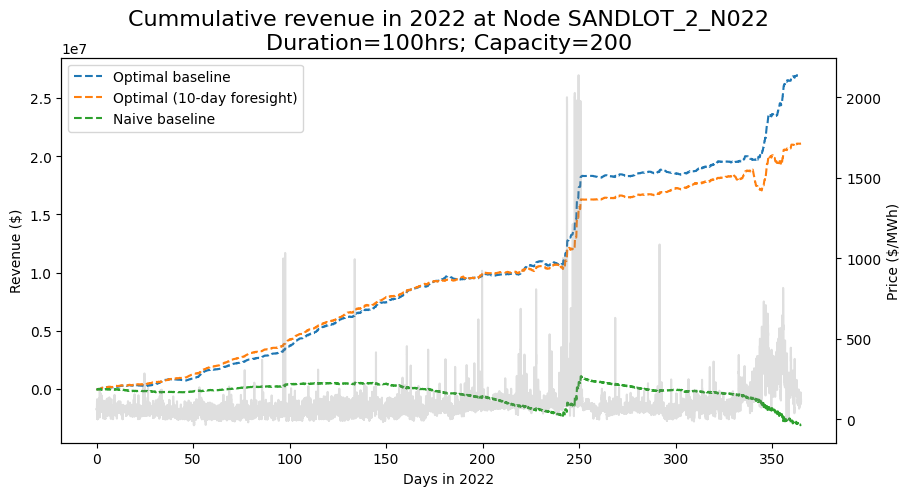

In [56]:
x = np.arange(len(p))/4/24
fig, axL = plt.subplots(figsize=(10, 5))
axR = axL.twinx()
axL.plot(x, revenue_opt, linestyle='--', label='Optimal baseline')
axL.plot(x, revenue_optlim, linestyle='--', label=f'Optimal ({foresight}-day foresight)')
axL.plot(x[:-1], revenue_n, linestyle='--', label='Naive baseline')

axR.plot(x, p, alpha=0.25, color='grey')
axL.set_title(f'Cummulative revenue in {y} at Node {node}\nDuration={dur}hrs; Capacity={capacity}')
axL.set_ylabel('Revenue ($)')
axR.set_ylabel('Price ($/MWh)')
axL.set_xlabel(f'Days in {y}')
axL.legend()
plt.show()